# Week7 - Decision Tree Lab & HW

## LAB

* Do a quick EDA to understand your data and explain what you need for your pipeline.
* Explain what metric would be appropriate for this task (1 sentence).
* Explain your game plan
* Create a preprocessing pipeline (without the model).


## HW

* Train-test split
* Create 2 new pipelines for the following 2 models and use preprocessing pipeline you created in the previous step
    * a decison tree model https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
    * a random forest model https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
* Define params for GridSearchCV for both models
* Evaluate the models

* Explain findings

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [3]:
# DON'T CHANGE ANYTHING HERE....

random.seed(42)
def remove_values(df, cols, perc=0.001):
    for i in cols:
        mask = pd.Series(random.choices([0,1], weights=[perc, 1-perc], k=len(df[i])))
        df[i] = [ x if i==1 else None for x, i in zip(df[i], mask)]

def create_df(size=1000000):
    from sklearn.datasets import make_classification

    X, y = make_classification(
        n_samples=size,
        n_features=5,
        n_informative=5,
        n_redundant=0,
        n_classes=2,
        flip_y=0.2,
        random_state=4
    )

    df = pd.DataFrame(X)
    df.columns = ['f1', 'f2', 'f3', 'f4', 'f5']
    df.f1 = df.f1**2
    df.f2 = df.f2**2
    df.f3 = df.f3*1000

    flag = random.choices([True, False], weights=[0.65, 0.35], k=len(y))
    f6 = ['A' if i == 0 else 'B' for i in y]

    f6 = [f if i else ('B' if f=='A' else 'A') for i,f in zip(flag, f6)]
    df['f6'] = f6

    remove_values(df, df.columns, perc=0.05)

    return df, pd.Series(y)

X, y = create_df()

In [4]:
X.shape

(1000000, 6)

In [5]:
# eda code
X.head()

,f1,f2,f3,f4,f5,f6
0,3.083178,3.022878,1276.390696,-2.672085,1.085629,B
1,NaN,1.764094,-873.709051,2.084035,0.387268,A
2,8.663599,NaN,-563.461158,-0.044922,2.512673,A
3,NaN,3.899908,753.129656,1.565944,-3.771516,A
4,0.684772,22.623978,-392.739840,-0.136113,-2.028027,A


In [6]:
X.head().T

,0,1,2,3,4
f1,3.083178,NaN,8.663599,NaN,0.684772
f2,3.022878,1.764094,NaN,3.899908,22.623978
f3,1276.390696,-873.709051,-563.461158,753.129656,-392.73984
f4,-2.672085,2.084035,-0.044922,1.565944,-0.136113
f5,1.085629,0.387268,2.512673,-3.771516,-2.028027
f6,B,A,A,A,A


In [7]:
X.describe()

,f1,f2,f3,f4,f5
count,9.499330e+05,9.498840e+05,949804.000000,950444.000000,950149.000000
mean,2.970269e+00,2.698242e+00,1.203865,-0.002337,-0.000394
std,4.223559e+00,3.863111e+00,1441.308642,1.682211,1.683646
min,7.464873e-15,4.200556e-12,-6319.721066,-8.364699,-7.067953
25%,3.265102e-01,3.144912e-01,-1077.181298,-1.172712,-1.186616
50%,1.415231e+00,1.310581e+00,-403.563631,0.067817,0.001923
75%,3.905995e+00,3.501739e+00,1009.950057,1.156616,1.152483
max,9.069379e+01,8.512300e+01,7402.596849,9.717087,8.354947


<Axes: >

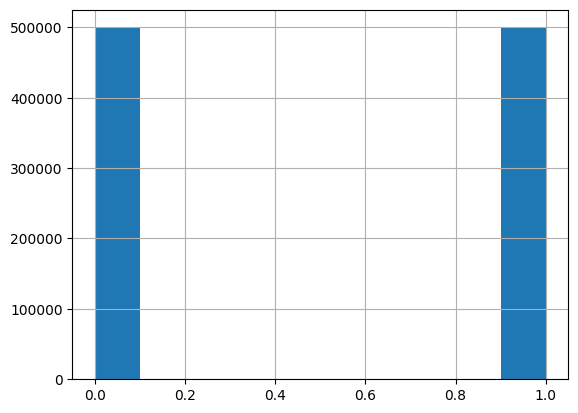

In [8]:
y.hist()

In [9]:
X.isna().sum()

f1    50067
f2    50116
f3    50196
f4    49556
f5    49851
f6    50017
dtype: int64

Explainations...

I would like to say that the F1score is best for a particular task to make a binary classification task. Its a good metric becuase it shows the precision and recall to get a good balance on both.

What do you need for the pipe line:

My first step is to understand the problem and do eda for the data set to know what we are about do in the next steps.

Second step is to handle the missing values and encoding the categorical to numerical and here i observed that f6 has values A and B and it has to be converted into numeric

Third step is to to select the appropriate model which suits the best F1score and by doing feature scaling and selection if it is needed.

Explain your gameplan...

Generate a subset of the current dataset containing balanced features to streamline processing and facilitate GridSearchCV.

Develop a pipeline processor to handle missing values imputation and categorical values encoding.

Conduct GridSearchCV to identify optimal parameters for both models, assess model performance, and select the most effective algorithm.

In [10]:
# create processing pipeline

In [11]:
y

0         1
1         0
2         0
3         0
4         1
         ..
999995    0
999996    0
999997    0
999998    1
999999    0
Length: 1000000, dtype: int64

In [12]:
def create_balanced_subset(X, y, sample_size=10000):
    # Separate samples for each class
    class_0_indices = np.where(y == 0)[0]
    class_1_indices = np.where(y == 1)[0]

    # Shuffle the class indices
    np.random.shuffle(class_0_indices)
    np.random.shuffle(class_1_indices)

# Take the first sample_size//2 indices from each shuffled class
    balanced_indices = np.concatenate([class_0_indices[:sample_size//2], class_1_indices[:sample_size//2]])

    X_subset = X.iloc[balanced_indices]
    y_subset = y.iloc[balanced_indices]

    return X_subset, y_subset

X_sub, y_sub = create_balanced_subset(X, y)

y_sub.value_counts()

0    5000
1    5000
dtype: int64

In [13]:
X_sub = X_sub.drop(columns=['f6'])

In [14]:
numeric_features = X_sub.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_sub.select_dtypes(include=['object']).columns.tolist()

numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
processing_pipeline = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])

processing_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['f1', 'f2', 'f3', 'f4', 'f5']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 [])])

## HW

In [15]:
from sklearn.model_selection import train_test_split

# Performing train-test split
X_train, X_test, y_train, y_test = train_test_split(X_sub, y_sub, test_size=0.2, random_state=42)

print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (8000, 5) (8000,)
Test set shape: (2000, 5) (2000,)


In [16]:
dt_modeling_pipeline = Pipeline([
    ('data_processing', processing_pipeline),
    ('ml', DecisionTreeClassifier())]
)
dt_modeling_pipeline

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['f1', 'f2', 'f3', 'f4',
                                                   'f5']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('ml', DecisionTreeClassifier())])

In [17]:
dt_param_grid = [
    {
    'ml__max_depth': [None, 5, 10, 15],
    'ml__min_samples_split': [2, 5, 10],
    'ml__min_samples_leaf': [1, 2, 4]
    }
]

scoring ='f1'

dt_gc = GridSearchCV(estimator=dt_modeling_pipeline, param_grid=dt_param_grid, cv=5, scoring=scoring)
dt_gcv_results = dt_gc.fit(X_train, y_train)

In [18]:
dt_gcv_results.best_params_

{'ml__max_depth': 10, 'ml__min_samples_leaf': 1, 'ml__min_samples_split': 10}

In [19]:
dt_gcv_results.score(X_train, y_train)

0.8642197125256674

In [20]:
dt_gcv_results.score(X_test, y_test)

0.7780040733197555

In [21]:
rf_modeling_pipeline = Pipeline([
    ('data_processing', processing_pipeline),
    ('ml', RandomForestClassifier())]
)
rf_modeling_pipeline

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['f1', 'f2', 'f3', 'f4',
                                                   'f5']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('ml', RandomForestClassifier())])

In [22]:
rf_param_grid = {
    'ml__n_estimators': [10, 20, 30],
    'ml__max_depth': [5, 10, None],
    'ml__min_samples_split': [2, 5, 10],
    'ml__min_samples_leaf': [1, 2, 4]
}

scoring = 'f1'

rf_gc = GridSearchCV(estimator=rf_modeling_pipeline, param_grid=rf_param_grid, cv=5, scoring=scoring)
rf_gcv_results = rf_gc.fit(X_train, y_train)

In [24]:
rf_gcv_results.best_params_

{'ml__max_depth': None,
 'ml__min_samples_leaf': 2,
 'ml__min_samples_split': 10,
 'ml__n_estimators': 20}

In [25]:
rf_gcv_results.score(X_train, y_train)

0.9128537588829323

In [26]:
rf_gcv_results.score(X_test, y_test)

0.8183613030602171

Explain __shortly__ your findings how did you address the issues.

After performing the gridsearchCV, I have found  that train accuracy for both Decision Tree and Random Forest are some what similar with only a vast difference. I performed the grid search on subset of data due to memory constraints. However, Random Forest performs better on test accuracy.

To address the issue by finding the best hyper parameters for the model and the performance of each model on the train and test sets.

A comparison of the performance between the models which has best.

Explain which model would you go with?

The random forest has complex visualization and accurate predictions, but the decision tree has simple visualization and less accurate predictions

While decision tree model's Test accuracy is 77%, Random forest model's test accuracy is 81%. Random Forest model can be useful to reduce overfitting.

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train set shape on X and y:", X_train.shape, y_train.shape)
print("Test set shape on X and y:", X_test.shape, y_test.shape)

Train set shape on X and y: (800000, 5) (800000,)
Test set shape on X and y: (200000, 5) (200000,)


In [40]:
best_rf_pipeline.fit(X_train, y_train)

y_pred_best_rf = best_rf_pipeline.predict(X_test)

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)
precision_best_rf = precision_score(y_test, y_pred_best_rf)
recall_best_rf = recall_score(y_test, y_pred_best_rf)
f1_best_rf = f1_score(y_test, y_pred_best_rf)
conf_matrix_best_rf = confusion_matrix(y_test, y_pred_best_rf)

In [32]:
print("Random Forest Model Evaluation:")
print("Accuracy:", accuracy_best_rf)
print("Precision:", precision_best_rf)
print("Recall:", recall_best_rf)
print("F1 Score:", f1_best_rf)
print("Confusion Matrix:")
print(conf_matrix_best_rf)

Random Forest Model Evaluation:
Accuracy: 0.842795
Precision: 0.8448793517226144
Recall: 0.840280829305317
F1 Score: 0.8425738162117775
Confusion Matrix:
[[84420 15448]
 [15993 84139]]




It says that random forest has 84.2% on test data set by classifying.

Here precision tells that 84.4 % has positive rate and it was more when comapred with other metrics

Recall rates shows us that 84% of the times instances are actually positive.
F1 score is mean of Precision and Recall. Model acheived good balance of 84%

By this ee can say that model is performing good with high accuracy, precision, recall & F1 score.
